[[0. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1. 1.]
 [1. 1. 1. 0. 1. 1.]
 [1. 1. 1. 1. 0. 1.]
 [1. 1. 1. 1. 1. 0.]]
[[  0. 146.   8. 109. 123. 147.]
 [146.   0.   3.  52. 118. 125.]
 [  8.   3.   0.  71. 167.  41.]
 [109.  52.  71.   0.   8. 133.]
 [123. 118. 167.   8.   0. 125.]
 [147. 125.  41. 133. 125.   0.]]

Temps total d'exécution: 0.0 secondes
{0: [0, 1, 0], 1: [0, 3, 0], 2: [0, 5, 0], 3: [0, 4, 0], 4: [0, 2, 0]}
4
La valeur du chemin initial est : 966.0

---------------------------------------------

Sa valeur est de : 378.0 mn, soit 6.30 h

Temps d'execution : 0.007999897003173828 secondes


{0: [0, 2, 1, 5, 4, 3]}


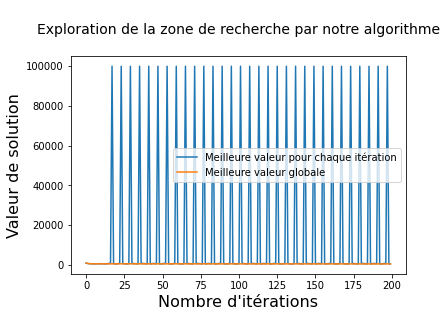

In [143]:
import numpy as np
from pulp import *
import time
import matplotlib.pyplot as plt
import timeit
import random
from copy import deepcopy
from functools import lru_cache
from ipywidgets import IntProgress
from IPython.display import display
from collections import deque
import networkx as nx


random.seed(10)
nb_villes = 6 #Nombre de villes à générer
minVehicule = 2
maxVehicule = 5
tempsMax=200 #Temps (Distance) max séparant 2 villes

def generer_matrice_adjacence(taille,typeDeGraphe):
    matrice = np.empty((taille, taille))              
    if(typeDeGraphe == 'Complete'):               
        for i in range(taille):
            for j in range(i,taille):
                valeur = 1 if i!=j else 0 
                matrice[i][j] = valeur
                matrice[j][i] = valeur
    else:
         for i in range(taille):
            for j in range(i,taille):
                valeur = random.randint(0, 1)  if i!=j else 0
                matrice[i][j] = valeur
                matrice[i][j] = valeur
    return matrice
    

matriceAdjacence = generer_matrice_adjacence(nb_villes, "Complete")
print(matriceAdjacence)

def generer_matrice_pondere(matrice):
    for i in range(len(matrice)):
        for j in range(i,len(matrice)):
            if(matrice[i][j] != 0):
                valeur = random.randint(0, tempsMax)
                matrice[i][j] = valeur
                matrice[j][i] = valeur
    return matrice



start = time.time() #Commence le calcul du temps d'exécution
graphe = generer_matrice_pondere(matriceAdjacence) ##Génère une matrice pour n villes et avec un temps maximum
print(graphe)
stop = time.time() #Stop le calcul du temps d'exécution

print("\nTemps total d'exécution: " + str(stop-start) + " secondes")



#Renvoi le temps total d'un chemin
def weightSol(sol,graphe):
    return sum(graphe[sol[i][j]][sol[i][j+1]] for i in sol for j in range(len(sol[i])-1))

#Donne le chemin à suivre du voyageur de commerce sous forme de tableau d'indice
def generate_solution(matrice,minVehicule,maxVehicule):
    sol = {}
    matriceSearch = [i for i in range(len(matrice))]
    matriceSearch.remove(0)
    i = 0
    nbvehicule = random.randint(minVehicule,maxVehicule)
    while (len(matriceSearch) > 0):
        way = []
        way.append(0)
        for j in range(0,(len(matrice)//nbvehicule)) :
            if len(matriceSearch) > 0 :
                value = random.choice(matriceSearch)
                way.append(value)
                matriceSearch.remove(value)
            else: 
                break
        way.append(0)
        sol[i] = way
        i += 1
    return sol,nbvehicule

sol,nbvehicule=generate_solution(graphe,minVehicule,maxVehicule)
print(sol)
print(nbvehicule)

#Génère les voisins valides d'une solution
def reformSolution(solutionConcatenate:list):
    idx_list = [idx + 1 for idx in range(len(solutionConcatenate)-1) if solutionConcatenate[idx] == 0 and solutionConcatenate[idx+1]== 0 ]
    if len(idx_list) > 0:
        solutionTransform = [solutionConcatenate[i: j] for i, j in zip([0] + idx_list, idx_list +  ([len(solutionConcatenate)] if idx_list[-1] != len(solutionConcatenate) else []))]
        solutionFinal = [val for val in solutionTransform if val != [0] ]
        solution = {truck:way for truck,way in enumerate(solutionFinal)}
    else:
        solution = {0:solutionConcatenate}
    return solution

def voisinage(sol:dict):
    voisinage = []
    solution = []
    for truckWay in sol.values():
        solution += truckWay
    for i in range (1,len(solution)-1):
        for n in range(1,len(solution)-i-2):
            neighborPath=solution.copy()
            if solution[i] == 0:
               continue
            elif solution[i+n] == 0:
                index = n + 2
                neighborPath = solution[:i]+[solution[i],solution[i+index]]+solution[i+1:]
                neighborPath.pop(i+index+1)
                voisinage.append(reformSolution(neighborPath))
                neighborPath = solution[:i+index]+[solution[i+index],solution[i]]+solution[i+index+1:]
                neighborPath.pop(i)
                voisinage.append(reformSolution(neighborPath))
            else:
                neighborPath[i], neighborPath[i+n] = neighborPath[i+n], neighborPath[i]
                voisinage.append(reformSolution(neighborPath))
    return voisinage


def tabuSearch(sol, tabuLength, iterMax, graphe):

    nbIter = 0
    tabuList = list()

    initialElement = sol
    # variables solutions pour la recherche du voisin optimal non tabou
    currentElement = initialElement
    bestNeighbor=currentElement
    bestNeighborGlobal=currentElement

    # variables valeurs pour la recherche du voisin optimal non tabou
    bestCost=100000
    bestCostGlobal=100000

    # variables pour l'affichage
    nbTabou=0
    bestGlobalFound=0
    
    # liste des solutions courantes et des meilleures trouvées, pour afficher la trajectoire
    paths=list()
    bestPaths=list()
    
    while (nbIter<iterMax):
        nbIter += 1       
        bestCost=100000

        # on parcours tous les voisins de la solution courante
        for neighbor in voisinage(currentElement):
            if weightSol(neighbor,graphe) < bestCost:
                if neighbor not in tabuList:
                    bestCost = weightSol(neighbor,graphe)
                    bestNeighbor = neighbor
          
        # on met a jour la meilleure solution rencontree depuis le debut
        if bestCost<bestCostGlobal:
            bestGlobalFound+=1
            bestNeighborGlobal=bestNeighbor
            bestCostGlobal=bestCost
            #print("Meilleur global trouvé ! : " + str(bestNeighborGlobal) + " avec une valeur de :" + str(bestCostGlobal))
      
        bestPaths.append(bestCostGlobal)
        
        # on passe au meilleur voisin non tabou trouve     
        currentElement=bestNeighbor.copy()
        paths.append(bestCost)
        
        # on met a jour la liste tabou
        tabuList.append(bestNeighbor)

        # on supprime la solution la plus ancienne si la liste tabou à atteint sa taille maximale
        if len(tabuList) > tabuLength:
            del tabuList[0]

    # On insère à l'élément initiale la ville d'origine
    return bestNeighborGlobal, paths, bestPaths, initialElement


# Paramètres de génération du graphe

graphe = generer_matrice_pondere(matriceAdjacence)

# Modifier ce paramètre pour modifier le nombre d'itération maximum de la recherche tabou
iterMaximum=200
# Modifier ce paramètre pour modifier la taille maximum de la liste tabou
tabuMax=len(graphe)
# Modifier ce paramètre pour activer ou non l'utilisation du plus proche voisin comme chemin initial
useNearestNeighbor=True
# Modifier ce paramètre pour changer la ville de départ
departureCity=0

startTime = time.time()
sol, paths, bestPaths, initialPath=tabuSearch(sol, tabuLength=tabuMax, iterMax=iterMaximum, graphe=graphe)
execTime = (time.time() - startTime)

print("La valeur du chemin initial est :",str(weightSol(initialPath,graphe)))
print("\n---------------------------------------------")
#print("\nLe meilleur chemin trouvé est : " + str(resNearestNeighbor(sol)))
print("\nSa valeur est de : " + str(weightSol(sol,graphe)) + " mn, soit " + str("{:.2f}".format(weightSol(sol,graphe)/60)) + " h")
print("\nTemps d'execution : " + str(execTime) + " secondes\n\n")

# Affichage des résultats sur le graphique
plt.xlabel("Nombre d'itérations", fontsize=16)
plt.ylabel("Valeur de solution", fontsize=16)

res = plt.plot(range(iterMaximum), paths,label='Meilleure valeur pour chaque itération')
res = plt.plot(range(iterMaximum), bestPaths,label='Meilleure valeur globale')

plt.legend()
font2 = {'size':14}
plt.title("\nExploration de la zone de recherche par notre algorithme\n", loc = 'center',fontdict = font2)
print(sol)


{0: [0, 2, 1, 5, 4, 3]}


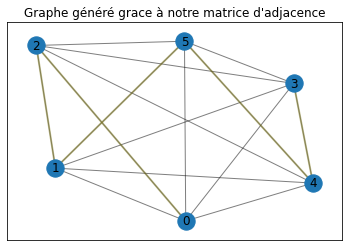

In [170]:
def traceGraph(sol:dict):
    print(sol)
    G = nx.Graph(matriceAdjacence, nodetype=int)
    pos = nx.spring_layout(G, seed=3113794652)  # positions for all nodes
    # nodes
    labels = nx.draw_networkx_labels(G, pos=pos)
    for Way in sol.values():
        hexadecimal = ["#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)])]
        nx.draw_networkx_nodes(G, pos, label = labels,nodelist=Way, node_color="tab:blue")
        # edges
        nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
        nx.draw_networkx_edges(
            G,
            pos,
            edgelist=[(Way[i],Way[i+1]) for i in range(len(Way)-1)],
            width=2,
            alpha=0.5,
            edge_color=hexadecimal[0],
        )
    plt.title("Graphe généré grace à notre matrice d'adjacence")
    plt.show()
traceGraph(sol)

In [2]:
def borne_inferieur():
    # variables
    x = [[[pulp.LpVariable("x%s_%s,%s"%(i,j,k), cat="Binary") if i != j else None for k in range(nbvehicule-1)] for j in range(nb_villes)] for i in range(nb_villes)]
    # probleme
    prob = LpProblem("vrp", LpMinimize)

    # fonction objective
    cost = lpSum(graphe[i][j] * x[i][j][k] if i != j else 0 for k in range(nbvehicule-1) for j in range(nb_villes) for i in range (nb_villes))
    prob += cost

    # contrainte
    for j in range(nb_villes):
        prob +=lpSum(x[i][j][k] if i != j else 0 for i in range(0,nb_villes) for k in range(nbvehicule-1)) == 1
    
    for k in range(nbvehicule-1):
        prob+= lpSum(x[0][j][k] for j in range(nb_villes)) == 1
        prob+= lpSum(x[i][0][k] for i in range(nb_villes)) == 1

    for k in range(nbvehicule-1):
        for j in range(nb_villes):
            prob+= lpSum(x[i][j][k] if i != j else 0 
                                  for i in range(nb_villes)) -  lpSum(x[j][i][k] for i in range(nb_villes)) == 0
    prob.solve()
    return value(prob.objective)

borne inferieur :  246.0
valeur de la solution : 343.0


IntProgress(value=0, layout=Layout(width='100%'), max=200)

Text(0.5, 1.0, 'Distribution des distances à la borne supérieure')

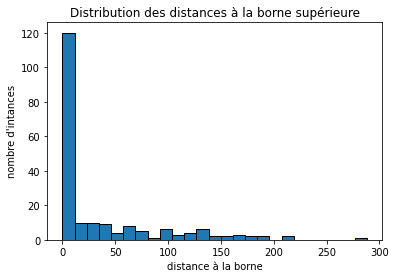

In [3]:
borne = borne_inferieur ()
if borne is not None:
    print("borne inferieur : ", borne)
print("valeur de la solution :", str(weightSol(sol,graphe)))


bornes = deque(())

# on affiche la barre de progression
bar = IntProgress(min=0, max=iterMaximum, layout={"width" : "100%"})
display(bar)
borne = borne_inferieur()
for i in range(iterMaximum):
    #À COMPLÉTER
    grapheborne = generer_matrice_pondere(matriceAdjacence)
    solu,nbvehicule = generate_solution(grapheborne,minVehicule,maxVehicule) 
    solOpti,paths, bestPaths, initialPath = tabuSearch(solu, tabuLength=tabuMax, iterMax=iterMaximum, graphe=grapheborne)                                                 
    val = int(weightSol(solOpti,grapheborne))                          
    distance = int(val*100/borne )
    bornes.append(distance)                             
    bar.value += 1    

# on cache la barre de progression
bar.close()

#À COMPLÉTER
plt.hist(bornes, bins=25, edgecolor = "black")                         
plt.xlabel("distance à la borne")                            
plt.ylabel("nombre d'intances")                              
plt.title("Distribution des distances à la borne supérieure")

In [4]:
import statistics
import numpy as np

print("médiane =",format(statistics.median(bornes))) 
print("moyenne ={:.2f}, écart-type={:.2f}".format(         
      statistics.fmean(bornes),np.std(bornes)))           


médiane = 0.0
moyenne =34.02, écart-type=55.31


IntProgress(value=0, layout=Layout(width='100%'), max=1900)

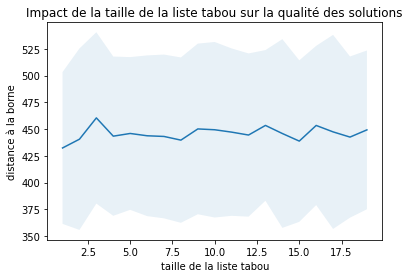

In [6]:

# paramètres du test
tabou_min = 1
tabou_max = 20
nb_villess = 10

nb_test  = 100
iter_max = 20

# on affiche la barre de progression
nb_steps_bar = (tabou_max-tabou_min)*nb_test
bar = IntProgress(min=0, max=nb_steps_bar, layout={"width" : "100%"})
display(bar)

# pour stocker les résultats
moyennes   = []
deviations = []


# cette fois on boucle sur la taille de la liste tabou
#À COMPLÉTER
for taille_tabou in range(tabou_min, tabou_max):            
    bornes = deque(())                              
    for _ in range(nb_test):                                
        # génération aléatoire de l'instance et calcul de   
        # sa borne supérieure.   
        matriceAdjacences = generer_matrice_adjacence(nb_villess, "Complete")                                                                                                    
        grapheborne = generer_matrice_pondere(matriceAdjacences)
        solu,nbvehicule = generate_solution(grapheborne,minVehicule,maxVehicule) 
        solOpti,paths, bestPaths, initialPath = tabuSearch(solu, tabuLength=tabuMax, iterMax=iterMaximum, graphe=grapheborne)                                           
        val = int(weightSol(sol,grapheborne))           
        bar.value += 1                 
        distance = int(val*100/borne)
        bornes.append(distance)                                                         
                                                            
    moyennes.append(statistics.fmean(bornes))               
    deviations.append(np.std(bornes))      

# on cache la barre de progression
bar.close()

# affichage de la courbe de moyenne
plt.plot(range(tabou_min, tabou_max), moyennes)

# affichage de la bande d'écart-type
plt.fill_between(range(tabou_min, tabou_max),
                 np.subtract(moyennes, deviations), # borne haute
                 np.add(moyennes, deviations),      # borne basse
                 alpha=.1)                          # transparence
plt.xlabel("taille de la liste tabou")
plt.ylabel("distance à la borne")
plt.title("Impact de la taille de la liste tabou sur la qualité des solutions")
plt.show()

In [ ]:

# paramètres du test
nbville_min   = 2
nbville_max   = 10
nbville_steps = 1
nb_test      = 200

taille_tabou = 5
iter_max   = taille_tabou*2

nb_steps_bar =\
    ((nbville_max-nbville_min)/nbville_steps)*nb_test #SOLUTION

# on affiche la barre de progression
bar = IntProgress(min=0, max=nb_steps_bar, layout={"width" : "100%"})
display(bar)

# pour stocker les résultats
moyennes   = []
deviations = []

# on fait varier le nombre d'nbville dans la génération aléatoire d'instances 
for nb_nbville in range(nbville_min, nbville_max, nbville_steps):
    bornes = deque(())                                        
    for _ in range(nb_test):                                 
        # génération aléatoire de l'instance et calcul de sa  
        # borne supérieure.                                                                                                          
        matriceAdjacences = generer_matrice_adjacence(nb_villess, "Complete")                                                                                                    
        grapheborne = generer_matrice_pondere(matriceAdjacences)
        solu,nbvehicule = generate_solution(grapheborne,minVehicule,maxVehicule) 
        solOpti,paths, bestPaths, initialPath = tabuSearch(solu, tabuLength=tabuMax, iterMax=iterMaximum, graphe=grapheborne)                                                
        val = int(weightSol(sol,grapheborne))   
        bar.value += 1                         
        distance = int(val*100/borne)
        bornes.append(distance)                              
    moyennes.append(statistics.fmean(bornes))                
    deviations.append(np.std(bornes))                        

# on cache la barre de progression
bar.close()

# affichage de la courbe de moyenne
plt.plot(range(nbville_min, nbville_max, nbville_steps), moyennes)

# affichage de la bande d'écart-type
plt.fill_between(range(nbville_min, nbville_max, nbville_steps),
                 np.subtract(moyennes, deviations), # borne haute
                 np.add(moyennes, deviations),      # borne basse
                 alpha=.1)                          # transparence
plt.ylim(top=100)
plt.xlabel("nombre de ville disponibles")
plt.ylabel("distance à la borne")
plt.title("Impact du nombre de ville sur la qualité des solutions")
plt.show()

IntProgress(value=0, layout=Layout(width='100%'), max=1600)

KeyboardInterrupt: 